In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def dbscale(darray):
    if len(np.shape(darray))==3:
        img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)
    else:
        img = 10*np.log10(abs(darray[:,:])**2)
    return img

def logScale(slices):
    
    logslices = np.copy(slices)
    nSlices = slices.shape[2]
    logslicesAmp = abs(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # and retrieve the phase
    logslicesPhase = np.angle(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # reescale amplitude
    logslicesAmp = np.log10(logslicesAmp)
    slicesMax = np.reshape(logslicesAmp.max(axis=(0, 1)), ( 1, 1,nSlices))
    slicesMin = np.reshape(logslicesAmp.min(axis=(0, 1)), ( 1, 1,nSlices))
    logslicesAmp = (logslicesAmp - slicesMin) / (slicesMax - slicesMin)
    # --- here, we could even normalize each slice to 0-1, keeping the original
    # --- limits to rescale after the network processes
    # and redefine the real and imaginary components with the new amplitude and
    # same phase
    logslices[:, :, :, 0] = (np.real(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    logslices[:, :, :, 1] = (np.imag(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    
    return logslices, slicesMax, slicesMin

def inverseLogScale(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesPhase = np.angle(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def inverseLogScaleSummary(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesPhase = np.angle(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices


In [3]:
dataPath = r'E:\DLOCT\Experimental_Data_complex'
tom = np.load(os.path.join(dataPath,'validationOpticNerve.npy'))
tomcc = np.load(os.path.join(dataPath,'validationOpticNervecc.npy'))
size = 512
initz = 256
initx1 = 0
initx2 = 512
tomHalfinit = tom[initz:initz+size,initx1:initx1+size,:,:]
tomHalfinitcc = tomcc[initz:initz+size,initx1:initx1+size,:,:]
tomHalfinit2 = tom[initz:initz+size,initx2:,:,:]
tomHalfinit2cc = tomcc[initz:initz+size,initx2:,:,:]


In [3]:

tomNorm,tmax,tmin = normalize_tomogram(tom)
tomccNorm,imax,imin = normalize_tomogram(tomcc)
tomNorm = np.transpose(tomNorm, (2, 0, 1, 3))
tomccNorm = np.transpose(tomccNorm, (2, 0, 1, 3))

In [4]:
path = r'E:\models\mse-mae_tanh_relu_7L'
modelName = 'model_026160.h5'
model = tf.keras.models.load_model(os.path.join(path,modelName), compile=False)



In [5]:
tomPredict = np.array(model.predict(tomccNorm, batch_size=1), dtype='float32')

10/10 [==============================] - 16s 125ms/step


In [12]:
tomNorm.shape

(10, 1024, 1024, 2)

Text(0.5, 1.0, 'Target')

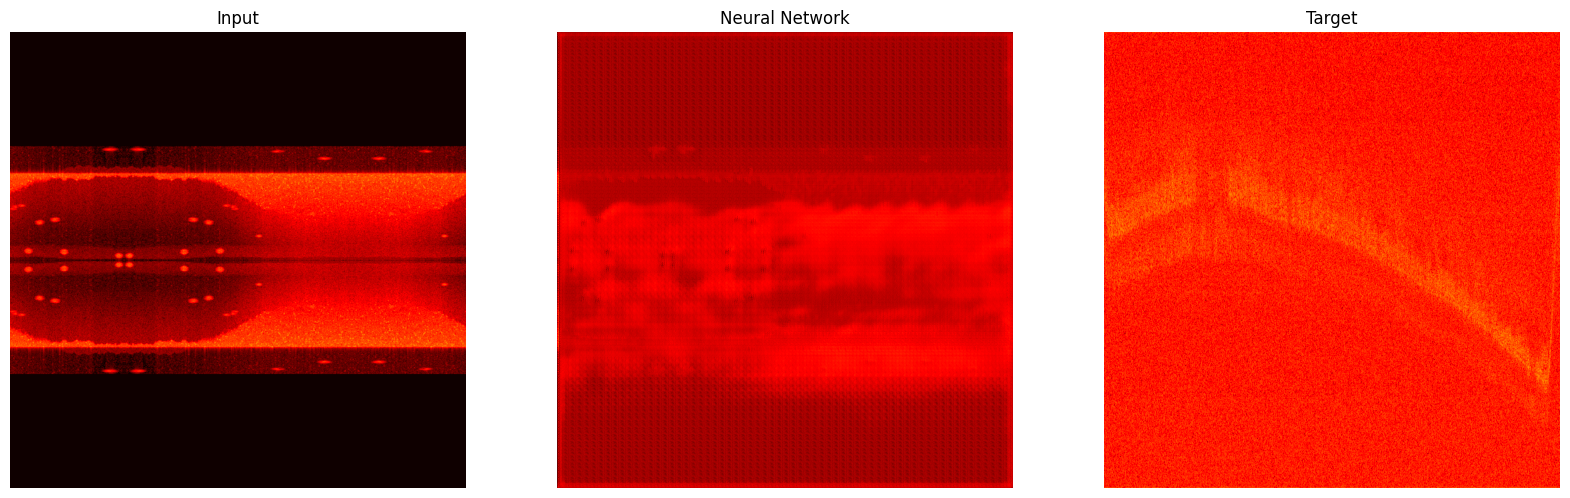

In [16]:
tomPredictreordered = np.transpose(tomPredict, (1, 2, 0, 3))
tomPredictFullScale = denormalize_tomogram(tomPredictreordered,imax,imin)
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(20,15))
axs[0].imshow(abs(tomccNorm[0,:,:,0]+1j*tomccNorm[0,:,:,1]),cmap='hot',vmax=2,vmin=0.5)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(abs(tomPredictreordered[:,:,0,0]+1j*tomPredictreordered[:,:,0,1]),cmap='hot',vmax=2,vmin=0.5)
axs[1].axis('off')
axs[1].set_title('Neural Network')
axs[2].imshow(abs(tomNorm[0,:,:,0]+1j*tomNorm[0,:,:,1]),cmap='hot',vmax=2,vmin=0.5)
axs[2].axis('off')
axs[2].set_title('Target')

In [7]:

def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

pathcomplex = r'C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom2'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
    real_file_path = os.path.join(pathcomplex, real_file)
    imag_file_path = os.path.join(pathcomplex, imag_file)
    print(f'real: {real_file_path}')
    print(f'imag: {imag_file_path}')
    dimensions = extract_dimensions(real_file[:-4])
    tomReal = read_tomogram(real_file_path, dimensions)
    tomImag = read_tomogram(imag_file_path, dimensions)
    tomcc = np.stack((tomReal,tomImag),axis=3)
    del tomImag, tomReal
tomsyntetic = np.pad(tomcc,pad_width=((256,256),(0,0),(0,0),(0,0)),mode='constant',constant_values=1)
tomsyntetic = np.pad(tomsyntetic,pad_width=((0,0),(256,256),(0,0),(0,0)),mode='reflect')
tomccNorm,imax,imin = normalize_tomogram(tomsyntetic)
tomccNorm = np.transpose(tomccNorm, (2, 0, 1, 3))

real: C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom2\tom2_real_val_z=512_x=512_y=8.bin
imag: C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom2\tom2_imag_val_z=512_x=512_y=8.bin


In [8]:
tomccNorm.shape

(8, 1024, 1024, 2)

In [9]:
tomPredict = np.array(model.predict(tomccNorm, batch_size=1), dtype='float32')
tomPredictreordered = np.transpose(tomPredict, (1, 2, 0, 3))

8/8 [==============================] - 1s 181ms/step


Text(0.5, 1.0, 'Neural Network')

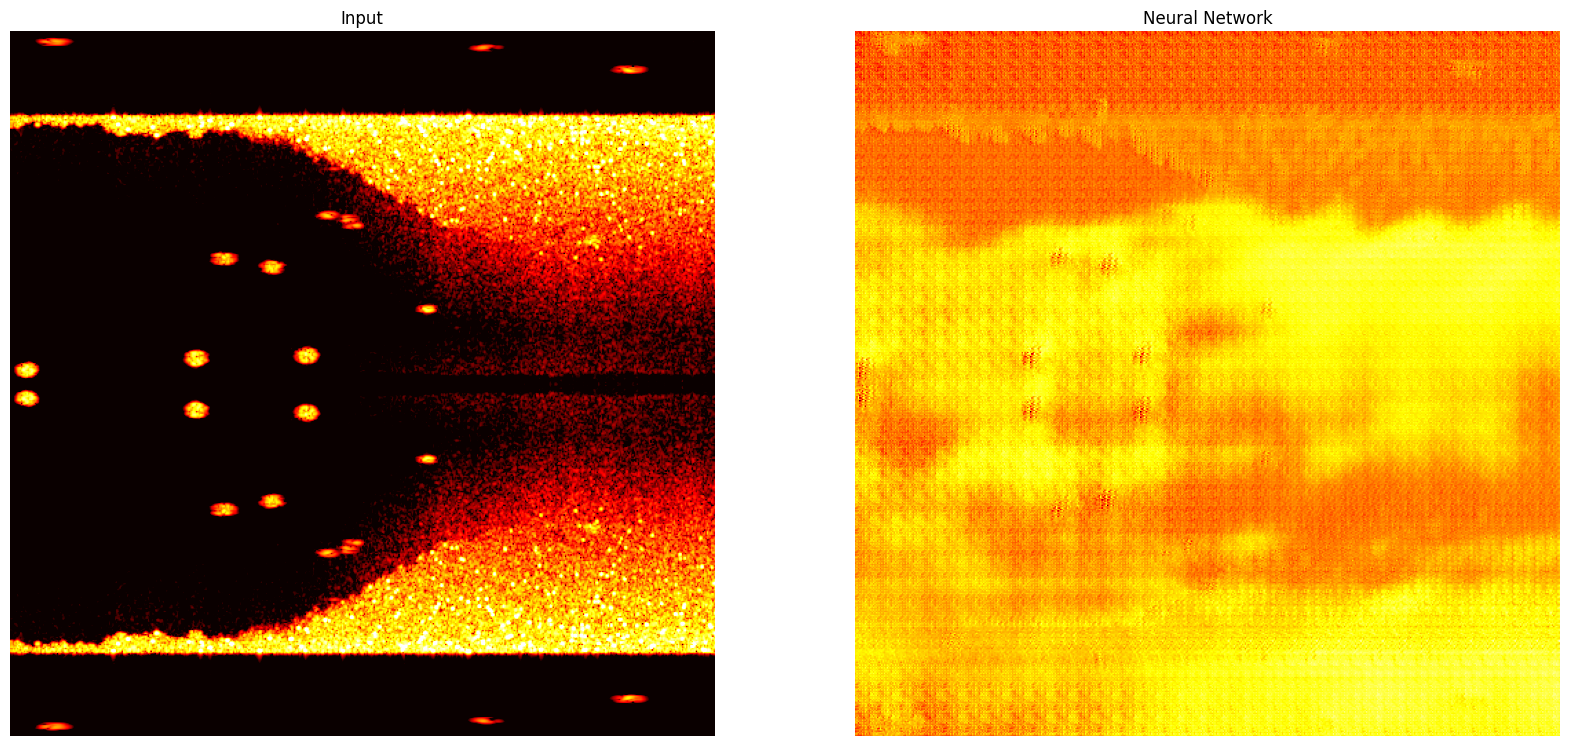

In [10]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(20,15))
axs[0].imshow(dbscale(tomcc[:,:,0,:]),cmap='hot',vmax=120,vmin=60)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(abs(tomPredictreordered[256:256+512,256:256+512,0,0]+1j*tomPredictreordered[256:256+512,256:256+512,0,1]),cmap='hot')
axs[1].axis('off')
axs[1].set_title('Neural Network')
